In [1169]:
import scipy.sparse as sp
from scipy.stats import mode
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.sparse.linalg import eigsh
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.cluster.spectral import discretize
from scipy.optimize import minimize_scalar

In [1122]:
def compute_W(X, n_neighbors=10, nn_radius='halfk'):
    knn = NearestNeighbors(n_neighbors, algorithm='auto', metric='sqeuclidean',
                           leaf_size=30, n_jobs=-1)
    knn.fit(X)
    W = knn.kneighbors_graph(n_neighbors=n_neighbors, mode='distance')

    if nn_radius == 'halfk':
        nn_radius = n_neighbors//2
        
    distances, _ = knn.kneighbors(n_neighbors=nn_radius)
    half_k_neighbors_distance = np.sqrt(distances[:,-1].squeeze())
    # normalization based on each points "neighbohood radius"
    for i in range(W.shape[0]):
        W[i,:] /= half_k_neighbors_distance[i]
    W = W.tocsc()
    for j in range(W.shape[0]):
         W[:,j] /= half_k_neighbors_distance[i]
        
    # comput exp over non zero entries (zero entries are distances non calculated)
    W *= -1
    W = W.expm1()
    W[W.nonzero()] += 1 # operation modifies W in place
    W.eliminate_zeros()
    return W

def compute_L(W, normalized=False,signless=False):
    if normalized:
        D = W.sum(axis=1).squeeze()
        invD = sp.dia_matrix((np.sqrt(1/D), 0), shape=W.shape)
        # Mutiplication by diagonal matrix = pointwise mutiplication
        term =  (invD*W*invD) if signless else (-invD*W*invD)
        L = sp.eye(W.shape[0]) + term
    else:
        D = sp.dia_matrix((W.sum(axis=1).squeeze(), 0),shape=W.shape)
        L = (D + W) if signless else (D - W)
    return L


In [1123]:
def SVD(L, k):
    """
    https://docs.scipy.org/doc/scipy/reference/tutorial/arpack.html
    Note that ARPACK is generally better at finding extremal eigenvalues: that
    is, eigenvalues with large magnitudes. In particular, using which = 'SM' 
    may lead to slow execution time and/or anomalous results. A better 
    approach is to use shift-invert mode.
    """
    from collections import namedtuple
    rng = np.random.RandomState(random_seed)
    v0 = rng.rand(L.shape[0])
    svd = namedtuple('SVD', ['singular_values_', 'singular_vectors_'])
    return svd(*eigsh(L, k=k, which='SM', maxiter=10000, tol=0, v0=v0))
    return svd(*eigsh(L, k=k, which='LM', sigma=0, maxiter=None, tol=0, v0=v0))
    

def reldiff(vector):
    return (np.diff(vector))/(1 + vector[0:-1])

def gap(eigvals):
    gaps = reldiff(eigvals)[0:]
#     return np.argmax(gaps) + 1
    dgaps = np.diff(gaps)
    for pos in range(2,len(dgaps)):
        if np.sign(dgaps[pos]) != np.sign(dgaps[pos-1]) :
            break
    return pos + 2

In [1124]:
random_seed=24
n_centers=4
mpl.rc('image',cmap=('tab10' if n_centers > 5 
                     else ('viridis' if n_centers==4 else 'prism')))

X, y = make_blobs(n_samples=500, n_features=2, 
                  centers=n_centers, cluster_std=1.5,
                  random_state=random_seed)
order = np.argsort(y)
X, y = X[order], y[order]

W = compute_W(X, n_neighbors=50, nn_radius=20)
L = compute_L(W)
Ln = compute_L(W, normalized=True)
Lp = compute_L(W, signless=True)

pcaL = SVD(L, L.shape[0]-1)
pcaLn = SVD(Ln, Ln.shape[0]-1)
pcaLp = SVD(Lp, Lp.shape[0]-1)
pcaW = SVD(W, W.shape[0]-1)

gap_n_clusters = gap(pcaLn.singular_values_)
print(gap_n_clusters, "clusters", reldiff(pcaLn.singular_values_[:10])[0:5])

4 clusters [0.00374042 0.02419638 0.06322171 0.03432462 0.01382891]


/mnt/Data/anaconda3/envs/pytorch04/lib/python3.6/site-packages/sklearn/utils/validation.py:709: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


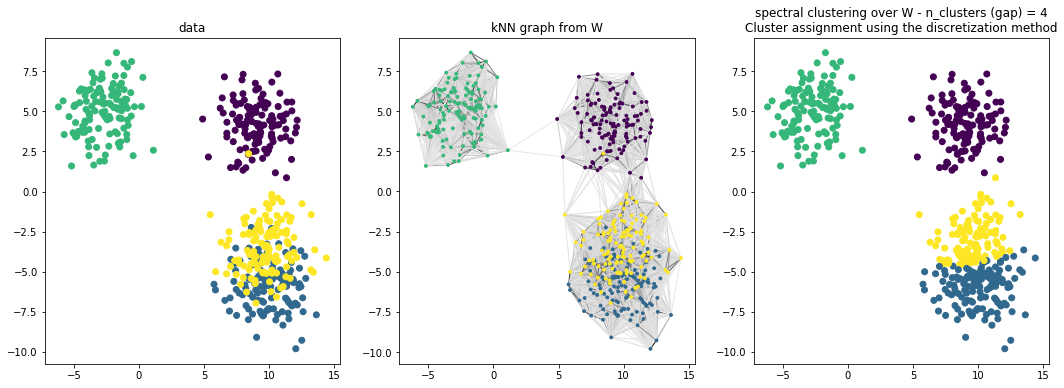

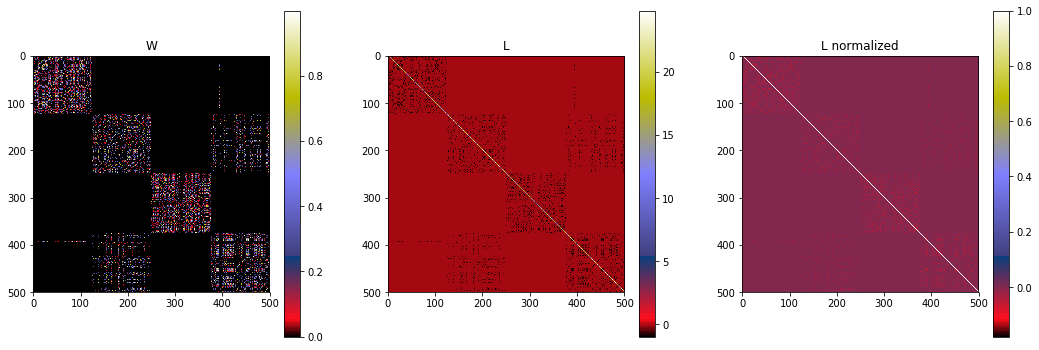

In [1125]:
n_plots = 3
plt.subplot(1,n_plots,1)
plt.scatter(*X.T, c=y)
plt.title('data')

plt.subplot(1,n_plots,2)
G = nx.from_scipy_sparse_matrix(W,)
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = lambda x: dict([(i,l) for i,l in enumerate(x)])
nx.draw_networkx(G,with_labels=False, pos=pos(X), 
                 node_size=8, node_color=y, 
                 edgelist=edges, edge_color=weights, 
                 edge_cmap=plt.cm.Greys, edge_vmin=-0.2)
plt.title('kNN graph from W')


scluster= SpectralClustering(
    n_clusters=gap_n_clusters, # spectral gap 
    eigen_solver='arpack', 
    affinity='precomputed', assign_labels='discretize',  # or kmeans
    random_state=random_seed)
scluster.fit(W)

plt.subplot(1,n_plots,3)
plt.scatter(*X.T, c=scluster.labels_)
title = 'spectral clustering over W'
title += " - n_clusters (gap) = %d\n" % gap_n_clusters
title += 'Cluster assignment using the discretization method'
plt.title(title)
plt.gcf().set_size_inches(18,6)

plt.figure()
titles = ['W', 'L', 'L normalized']
for i, mat in enumerate([W, L, Ln]):
    plt.subplot(1,3,i+1)
    plt.imshow(mat.todense(), cmap='gist_stern')
    plt.colorbar()
    plt.title(titles[i])
plt.gcf().set_size_inches(18,6)

In [1126]:
pcaLn.singular_vectors_.shape, pcaLn.singular_vectors_.T[:2:].shape

((500, 499), (2, 500))

(500, 2)


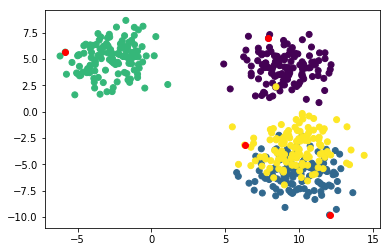

In [1127]:
Xemb=pcaLn.singular_vectors_[:,0:2]
centrality = eigsh(Ln,k=1, which='LM')[1].squeeze()
center = []
for i in range(gap_n_clusters):
    mask = (i==scluster.labels_)
    center.append(X[mask][np.argmax(centrality[mask])])
center = np.array(center)
print(Xemb.shape)
plt.scatter(*X.T, c=y)
plt.scatter(*center.T, c='r')

In [1225]:
import torch
a =  torch.Tensor([[1,2,3],[1,2,3]])
p = torch.Tensor([1,1,1])
torch.sum(a-p, dim=1)

tensor([3., 3.])

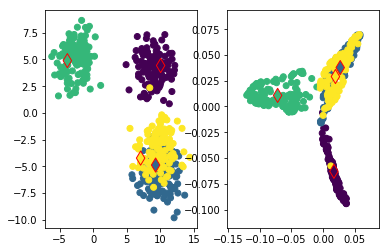

In [1200]:
# %%timeit
n_proto = gap_n_clusters
embedding = pcaLn.singular_vectors_[:,0:gap_n_clusters]
clusters = discretize(embedding, copy=True, random_state=random_seed)
protos = []
emb_protos = []
sup_proto_class = []
for i in range (n_proto):
    cluster_mask = (clusters==i)
    emb_masked = embedding[cluster_mask]
    emb_center = emb_masked.mean(axis=0)
    emb_protos.append(emb_center)
    emb_dist = np.linalg.norm(emb_masked-emb_center, axis=0)
    center_id = np.argmin(emb_dist)
    center = X[cluster_mask][center_id]
    protos.append(center)
    # sup_proto_class.append(y[cluster_mask][center_id])
    sup_proto_class.append(mode(y[cluster_mask])[0])

protos = np.array(protos)
emb_protos = np.array(emb_protos)
sup_proto_class = np.array(sup_proto_class).squeeze()
plt.subplot(1, 2, 1)
plt.scatter(*X[:,0:2].T, c=y)
plt.scatter(*protos[:,0:2].T, s=100, marker='d', c=sup_proto_class, edgecolors='r')
# plt.scatter(*protos[:,0:2].T, s=100, marker='d', c=sup_proto_class)
plt.subplot(1, 2, 2)
plt.scatter(*embedding[:,0:2].T, c=y)
plt.scatter(*emb_protos[:,0:2].T, s=100, marker='d', c=sup_proto_class, edgecolors='r')

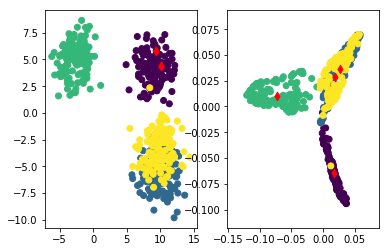

In [1167]:
# %%timeit
n_proto = gap_n_clusters
embedding = pcaLn.singular_vectors_[:,0:gap_n_clusters]
clusters = discretize(embedding, copy=True)
protos = []
emb_protos = []
kmeans = KMeans(n_proto, init='k-means++', n_init=20, random_state=random_seed)
kmeans.fit(embedding)
clusters = kmeans.labels_
for i in range (n_proto):
    mask = (clusters==i)
    emb_masked = embedding[mask]
    emb_center = kmeans.cluster_centers_[i]
    emb_protos.append(emb_center)
    emb_dist = np.linalg.norm(emb_masked-emb_center, axis=0)
    center = X[cluster_mask][np.argmin(emb_dist)]
    protos.append(center)
protos = np.array(protos)
emb_protos = np.array(emb_protos)
plt.subplot(1,2,1)
plt.scatter(*X[:,0:2].T, c=y)
plt.scatter(*protos[:,0:2].T, marker='d', c='red')
plt.subplot(1,2,2)
plt.scatter(*embedding[:,0:2].T, c=y)
plt.scatter(*emb_protos[:,0:2].T, marker='d', c='r')

In [ ]:
nx.algorithms.is_connected(G)

In [ ]:
lim=20
plt.subplot(1,2,1)
plt.title('L eigenvalues')
plt.plot(pcaL.singular_values_[:lim], 'o:')
plt.gca().twinx()
plt.stem(np.arange(lim-1)+0.5,reldiff(pcaL.singular_values_[0:lim]),
         ':C1','oC1')
plt.ylabel('gap')

plt.subplot(1,2,2)
plt.title('Lnormalized eigenvalues')
plt.plot(pcaLn.singular_values_[:lim], 'o:')
ax = plt.gca().twinx()
plt.stem(np.arange(lim-1)+0.5,reldiff(pcaLn.singular_values_[0:lim]),
         ':C1','oC1')

plt.ylabel('gap')
plt.gcf().set_size_inches(15,4)
pcaL.singular_values_[:10], pcaLn.singular_values_[:10]

In [ ]:
DG = nx.diameter(G)

In [ ]:
wvolG = nx.volume(G, G.nodes, weight='weight')
volG= nx.volume(G, G.nodes)

In [ ]:
1/DG*volG

In [ ]:
np.diff(reldiff(pcaLn.singular_values_[:5]))

## First singular vectors for L and Lnorm

In [ ]:
n=10
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.scatter(np.arange(L.shape[0]), pcaL.singular_vectors_[:,i],c=y)
plt.gcf().set_size_inches(20,4)

In [ ]:
n=10
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.scatter(np.arange(L.shape[0]), pcaLn.singular_vectors_[:,i],c=y)
plt.gcf().set_size_inches(20,4)